# Model Build

In [1]:
# %history -g -f jm_trg.py

In [2]:

import os
import math
import numpy as np
import glob
from typing import Any
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import metrics
from pandas import DataFrame, crosstab
from metrics import plot_confusion
from IPython.display import Image
from tensorflow.keras import models
from keras.utils import plot_model
from tqdm.notebook import trange
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import (
            f1_score, accuracy_score, precision_score, recall_score, classification_report)
from data import load_data
from wordcloud import WordCloud
from timer import timer
import umap

In [3]:
from sklearn.metrics import pairwise
def pairwise_sqd_distance(X):
    return pairwise.pairwise_distances(X, metric='sqeuclidean')

def make_q(z, batch_size, alpha):

    sqd_dist_mat = np.float32(pairwise_sqd_distance(z))
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / tf.reduce_sum(q, axis=0, keepdims=True)
    # q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)
    
    return q

In [4]:
from linear_assignment import linear_assignment

def cluster_acc(y_true, y_pred, y_pred_cluster):
    y_true = y_true.astype(np.int64)
    assert y_pred_cluster.size == y_true.size
    D = max(y_pred_cluster.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred_cluster.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    c_loss = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred_cluster.size
    print(f"Cluster Loss {c_loss} on {y_pred_cluster.size} clusters")
    return c_loss

In [5]:
from tabnanny import verbose
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import mixture
from scipy.stats import multivariate_normal

def do_clustering(
        clustering: str, n_clusters: int, z_state: DataFrame, params={}):
    """
    Perform clustering on the data.
        -clustering: the clustering algorithm to use
        -n_clusters: the number of clusters to use
        -z_state: the data to cluster
        -params: dict, optional
            'eps' or 'min_samples' values for DBSCAN/OPTICS
    Returns:
        - the cluster assignments
        - cluster centers
    """
    dbscan_eps = 1
    dbscan_min_samples = 5
    
    if 'eps' in params:
        dbscan_eps = params['eps']
    if 'min_samples' in params:
        dbscan_min_samples = params['min_samples']

    if clustering == 'GMM':
        gmix = mixture.GaussianMixture(
                        n_components=n_clusters,
                        covariance_type='full',
                        verbose=params['verbose'])
        gmix.fit(z_state)
        y_pred = gmix.predict(z_state)
        # get centres
        centers = np.empty(shape=(gmix.n_components, z_state.shape[1]))
        for i in range(gmix.n_components):
            density = multivariate_normal(
                cov=gmix.covariances_[i],
                mean=gmix.means_[i]).logpdf(z_state)
            centers[i, :] = z_state[np.argmax(density)]
    elif clustering == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, verbose=params['verbose'])
        y_pred = kmeans.fit_predict(z_state)
        centers = kmeans.cluster_centers_
    elif clustering == 'DBSCAN':
        dbscan = DBSCAN(
            eps=dbscan_eps,
            min_samples=dbscan_min_samples,
            metric='manhattan')
        y_pred = dbscan.fit_predict(z_state)
        centers = np.zeros((len(np.unique(y_pred))))
    elif clustering == 'OPTICS':
        optics = OPTICS(
            min_samples=dbscan_min_samples, 
            min_cluster_size=5,
            metric='manhattan')
        y_pred = optics.fit_predict(z_state)
        centers = np.zeros((len(np.unique(y_pred))))
    elif clustering=="agg":
        agg = AgglomerativeClustering(
            n_clusters=n_clusters,
            affinity='euclidean',
            linkage='ward')
        y_pred = agg.fit_predict(z_state)
        centers = None
    else:
        raise ValueError('Clustering algorithm not specified/unknown.')

    return y_pred, centers

In [6]:
def freqs_descending(df, col):
    uniques, counts = np.unique(df[col], return_counts=True)
    freq_list = np.asarray((uniques, counts)).T
    freq_list2 =  np.asarray(sorted(freq_list, key=lambda x: -x[1]))
    # purity
    y_true_this_cluster = len(
            df[df[col]==freq_list2[0][0]])
    frac = y_true_this_cluster/len(df)
    return freq_list2, frac

In [7]:
# write_messages.py

from jinja2 import Environment, FileSystemLoader
from pathlib import Path

def write_results_page(clusters, new_clusters, save_dir, test_name, scores):
    
    environment = Environment(loader=FileSystemLoader("templates/"))
    template = environment.get_template("index.jinja")

    results_filename = os.path.join(save_dir, "index.html")
    results_template = environment.get_template("index.jinja")
    context = {
        "clusters": clusters,
        "new_clusters": new_clusters,
        "test_name": test_name,
        "metrics": scores,
    }
    with open(results_filename, mode="w", encoding="utf-8") as results:
        results.write(results_template.render(context))
        full_filename = Path(results_filename).absolute()
        print (f'... wrote results  <a href="{full_filename}">{full_filename}</a>')

In [8]:
from ast import NamedExpr


def show_wordcloud(
    i: int,
    freqs: np.ndarray,
    frac: float,
    name: str,
    filepath: str,
    n: int,
    width: int=16,
    save_only: bool=False)-> None:
    """
    Show wordcloud for a cluster.
    """
    if len(freqs) > 0:
        wc = WordCloud(width=800, height=500).generate_from_frequencies(freqs)
        if not save_only:
            plt.figure(figsize=(width, width-1))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()
        wc.to_file(filepath)
    else:
        print(f"No words for cluster {name}")

In [9]:
import warnings
warnings.filterwarnings("ignore")

ENTITY_FILTER_LIST = ['GPE', 'PERSON', 'ORG', 'DATE', 'NORP',
                      'TIME', 'PERCENT', 'LOC', 'QUANTITY', 'MONEY', 'FAC', 'CARDINAL',
                      'EVENT', 'PRODUCT', 'WORK_OF_ART', 'ORDINAL', 'LANGUAGE']


class DeepLatentCluster():

    def __init__(
        self,
        run_name: str,
        config: dict = None,
        verbose: int = 1,
    ):

        self.x = None
        self.y = None
        self.mapping = None
        self.strings = None
        self.y_pred_last = None
        self.input_dim = 768
        self.batch_size = 256

        self.run_name = run_name
        self.model = None
        self.encoder = None
        self.autoencoder = None
        self.save_dir = None
        self.verbose = verbose

        # latent model config
        self.config = {
            "layers_ae": [
                {"n": 500, "act": None},
                {"n": 500, "act": None},
                {"n": 2000, "act": None},
            ],
            "layer_ae_latent":
                {"n": 40, "act": None},
            "layers_latent_network": [
                {"n": 2000, "act": None},
                {"n": 500, "act": None},
                {"n": 500, "act": None},
            ],
            "output_fn": 'sigmoid',
            "opt": k.optimizers.Adam(
                lr=0.001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=None,
                decay=0.0,
                amsgrad=False),
            "noise_factor": 0.0,
            "loss": k.losses.binary_crossentropy,
            "train_size": 10000,
            "num_clusters": 25,
            "cluster": "GMM",
            "radius": 0,
            "entities": None,
            "entity_count": 10,
            "loss_weights": None,
            "latent_weight": 0.0001,
            "reconstr_weight": 1.0,
            "max_iter": 8000,
            "pretrain_epochs": 1000,
            "emb_size": 768,
            "alpha1": 20,
            "alpha2": 1,
            "ae_init_fn": VarianceScaling(
                mode='fan_in',
                scale=1. / 3.,
                distribution='uniform'),
            "base_dir": "results",
        }
        if config is not None:
            if any([k for k in config.keys() if k not in self.config.keys()]):
                print(f"ERROR: Invalid config key {k}")
            self.config = {**self.config, **config}
            
        if self.config['entities'] is not None and self.config['entity_count'] > 0:
            raise ValueError(
                'entities and entity_count cannot both be specified')
        if self.config['entities'] is None:
            if self.config['entity_count'] == 0:
                self.config['entities'] = ENTITY_FILTER_LIST
            else:
                self.config['entities'] = ENTITY_FILTER_LIST[
                    :self.config['entity_count']]


        self.save_dir = f'./{self.config["base_dir"]}/{self.run_name}'
        if not os.path.exists(self.save_dir):
            # create save dir
            os.makedirs(self.save_dir)

    def output(self, s: str) -> None:
        if self.verbose > 0:
            print(s)

    def make_data(self, oversample: bool = True, train: bool=True) -> None:

        self.output("Load Data")
        self.x, self.y, self.mapping, self.strings = load_data(
            self.config['train_size'],
            entity_filter=self.config['entities'],
            get_text=True,
            oversample=oversample,
            verbose=self.verbose,
            radius=self.config['radius'],
            train=train)
        self.input_dim = self.x.shape[1]
        self.output("Data Loaded")

    @staticmethod
    def create_layer(config: dict, name: str, init_fn: str = 'glorot_uniform') -> Dense:
        """
        Create a layer from a config dictionary.
        - config: dictionary of layer parameters
            - n: number of units
            - act: activation function
        """
        return Dense(
            name=name,
            units=config["n"],
            activation=config["act"],
            kernel_initializer=init_fn,
            kernel_regularizer='l1')

    def autoencoder_model(self, layer_specs: list, act: str = 'tanh', init_fn: str = 'glorot_uniform'):
        """
        Creates the autoencoder given
        -layer_specs: list of layer sizes.
            Model is symmetrical so only need to specify the first half.
        -act: activation function for hidden layers
        -init_fn: initializer for weights

        returns:
            - the full autoencoder
            - the encoder only
        """
        layers = len(layer_specs) - 1
        # input
        input_img = Input(shape=(layer_specs[0],), name='input')
        x = input_img
        encoder = [input_img]
        # hidden layers in encoder
        for i in range(layers-1):
            layer = Dense(
                layer_specs[i + 1],
                activation=act,
                kernel_initializer=init_fn,
                name=f'encoder_{i}')(encoder[-1])
            encoder += [layer]
            if self.verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i+1]} '
                      f'activation={act}')

        # latent layer
        latent = Dense(
            layer_specs[-1],
            kernel_initializer=init_fn,
            name=f'encoder_{layers - 1}')(encoder[-1])
        encoder += [latent]
        if self.verbose >= 2:
            print(f'encoder_{layers - 1}: {layer_specs[-1]}')

        autoencoder = [encoder[-1]]
        # hidden layers in decoder
        for i in range(layers-1, 0, -1):
            layer = Dense(
                layer_specs[i],
                activation=act,
                kernel_initializer=init_fn,
                name=f'decoder_{i}')(autoencoder[-1])
            autoencoder += [layer]
            if self.verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i]}'
                      f' activation={act}')

        # output
        layer = Dense(
            layer_specs[0],
            kernel_initializer=init_fn,
            name='decoder_0')(autoencoder[-1])
        autoencoder += [layer]
        if self.verbose >= 2:
            print(f'output: {layer_specs[0]}'
                  f'')
        return (encoder, autoencoder)

    def create_latent_space_model(self, input_layer: Dense) -> Model:
        """
        Create the model for the latent space
        - input_layer: previous model output layer
        """
        # build ml, the array of layers
        ml = [input_layer]
        layers = self.config['layers_latent_network']
        for n, l in enumerate(layers):
            ml.append(self.create_layer(l, f"latent_{n}")(ml[-1]))

        out_config = {**layers[0], "act": self.config['output_fn']}
        ml.append(self.create_layer(out_config, "latent_out")(ml[-1]))
        return ml

    def create_model(self) -> Model:
        """
        Create the entire model.

        """
        self.output("Autoencoder")
        enc, dec = self.autoencoder_model(
            [768, 500, 500, 2000, 40],
            init_fn=self.config['ae_init_fn'],
            act='relu',
        )

        self.output("Latent Model")
        latent_space = self.create_latent_space_model(
            input_layer=enc[-1])
        self.model = k.Model(
            name="full-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
                latent_space[-1],
            ])

        self.autoencoder = k.Model(
            name="ae-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
            ])

        self.encoder = k.Model(
            name="encoder",
            inputs=enc[0],
            outputs=[
                enc[-1],
            ])

    def make_model(self, verbose: int=None) -> None:
        if verbose is not None:
            self.verbose = verbose

        self.create_model()

        self.model.compile(
            loss=[
                self.latent_loss(
                    self.model.get_layer("encoder_2").get_weights()[0])],
            # loss_weights=self.config['loss_weights'],
            optimizer=SGD(learning_rate=0.5, momentum=0.9))
        self.output("model compiled")

        self.autoencoder.compile(optimizer='adam', loss='mse')

        img_file = os.path.join(self.save_dir, f'{self.run_name}_model.png')
        plot_model(self.model, to_file=img_file, show_shapes=True)
        Image(filename=img_file)

    def reconstr_loss(self, x, x_pred):
        return tf.reduce_mean(tf.square(tf.subtract(x, x_pred)))

    def latent_loss(self, z_enc):
        def loss(y, y_pred):
            p = make_q(y_pred, self.batch_size, alpha=self.config['alpha1'])
            q = make_q(z_enc, self.batch_size, alpha=self.config['alpha2'])
            latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))
            return latent_loss
        return loss

    def train_model(self, verbose: int = 1) -> None:
        """
        Run the model.
        """
        self.verbose = verbose

        if self.x is None:
            self.make_data(oversample=True)
            self.output("Data Loaded")

        if self.model is None:
            self.make_model()

        self.output("Training autoencoder")
        early_stopping_cb = EarlyStopping(
            monitor='loss', patience=10, verbose=1, min_delta=0.00001)
        history = self.autoencoder.fit(
            self.x,
            self.x,
            batch_size=self.batch_size,
            epochs=self.config["pretrain_epochs"],
            verbose=self.verbose,
            callbacks=[early_stopping_cb],
        )
        self.autoencoder.save_weights(
            os.path.join(self.save_dir, 'ae_weights.h5'))
        self.output("Trained autoencoder")
        
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('Autoencoder pretraining loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        # # init cluster centres before train
        # self.init_cluster_centers()

        # train full model
        losses = self.train()
        # summarize history for loss
        plt.plot(losses)
        plt.title('Full model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        print("Training Done")

    def aux_target_distribution(self, q):
        # sum column wise
        row_sum = q.sum(axis=0)
        # q_ij ^2 / row sum
        top = q ** 2 / row_sum
        # then / column sum
        return (top.T / top.sum(axis=1)).T

    def train_step(self, x, y):
        if self.config['noise_factor'] > 0.0:
            x = x + self.config['noise_factor'] * tf.random.normal(
                                                        shape=tf.shape(x),
                                                        mean=0.0,
                                                        stddev=1.0,
                                                        dtype=tf.float32) 
            # x = tf.clip_by_value(x, 0.0, 1.0)
        with tf.GradientTape() as tape:
            dec, lat = self.model(x, training=True)
            loss_l = self.latent_loss(self.encoder(x))(y, lat)
            loss_r = self.reconstr_loss(x, dec)
            loss_value = self.config['latent_weight'] * loss_l +\
                self.config['reconstr_weight'] * loss_r

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer = self.config['opt']
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, lat)
        return loss_value

    def train(self):
        self.train_acc_metric = k.metrics.SparseCategoricalAccuracy()

        update_interval = 140
        index_array = np.arange(self.x.shape[0])
        tol = 1e-6  # tolerance threshold to stop training
        loss = 0
        index = 0
        update_interval = 140
        losses = []
        for ite in range(int(self.config['max_iter'])):
            if ite % update_interval == 0:
                self.output(f"Iter:{ite} -> loss:{loss}")
            idx = index_array[
                index * self.batch_size:
                min((index+1) * self.batch_size, self.x.shape[0])]
            loss = self.train_step(self.x[idx], self.y[idx])
            losses += [loss]
            # stop training if tolerance threshold is reached
            patience = 5
            max_delta = np.max(np.abs(losses[-patience:] - losses[-1]))
            if len(losses)>3 and max_delta < tol:
                print("Stop traing for tolerance threshold reached")
                break
        if self.verbose == 0:
            # final values
            print(f'Iter: {ite} loss={loss}')
        self.model.save_weights(os.path.join(
            self.save_dir, 'lat_model_final.h5'))
        return losses

    def cluster_pred_acc(self):
        NER_only = DataFrame({'y': self.y, 'y_clus': self.y_pred})
        unk_tuple = [k for k, v in self.mapping.items() if v == 'UNKNOWN']
        unk_idx = unk_tuple[0] if len(unk_tuple) > 0 else None
        NER_only.drop(NER_only.index[NER_only['y'] == unk_idx], inplace=True)
        NER_match = NER_only[NER_only['y'] == NER_only['y_clus']]
        # fraction that match
        frac = NER_match.shape[0]/NER_only.shape[0]
        return frac

    def make_load_model(self, load_dir):
        self.make_model()

        if load_dir is None:
            load_dir = self.save_dir
        else:
            load_dir = f'./{self.config["base_dir"]}/{load_dir}'

        ae_weights_file  = os.path.join(load_dir, 'ae_weights.h5')
        self.output(f"Loading AE weights from {ae_weights_file}")
        self.autoencoder.load_weights(ae_weights_file)

        model_weights_file = os.path.join(load_dir, 'lat_model_final.h5')
        self.output(f"Loading model weights from {model_weights_file}")
        self.model.load_weights(model_weights_file)


    @staticmethod
    def get_freqs(word_list):
        unique, counts = np.unique(word_list, return_counts=True)
        freq_list = np.asarray((unique, counts)).T
        freq_list = sorted(freq_list, key=lambda x: -x[1])[0:50]
        freqs = {w: f for w, f in freq_list}
        return freqs

    def get_sample(self, sample_size: int):
        if self.config['train_size'] != sample_size or self.x is None:
            self.output("Load Data ")
            self.x, self.y, self.mapping, self.strings = load_data(
                0,
                get_text=True,
                verbose=verbose,
                train=False)
            self.output(f"Test Data Loaded {self.x.shape}")

        # sample
        if sample_size > 0 and self.x.shape[0] > sample_size:
            sample_idx = np.random.choice(
                self.x.shape[0], sample_size, replace=False)
            y_sample = self.y[sample_idx]
            str_sample = self.strings[sample_idx]
            x_sample = self.x[sample_idx]
        else:
            x_sample = self.x
            y_sample = self.y
            str_sample = self.strings
        
        return x_sample, y_sample, str_sample
        
    def predict(self, sample_size: int, head: str=None):
        """
        Make predictions for the given sample size.
        Sample will be from Test dataset not Train data
        returns
            - latent space predictions
            - actual labels
            - the textual repr of each item
        """
        if head is None:
            head = 'z'
        self.output(f"Using [{head}] head for predictions")
        
        x_sample, y_sample, str_sample = self.get_sample(sample_size)

        # predict z space
        num_batches = math.ceil((1.0 * len(x_sample)) / self.batch_size)
        self.output(f"Predicting...{num_batches} batches of "
                    f"{self.batch_size} x {x_sample.shape[1]}")

        # run the model on sampled x in batches
        z_sample = []
        for i in trange(num_batches, disable=self.verbose == 0):
            idx = np.arange(
                i * self.batch_size,
                min(len(x_sample), (i + 1) * self.batch_size))
            x = x_sample[idx]
            if head == 'z':
                _, z_batch = self.model.predict(x, verbose=0)
            elif head == 'ae':
                z_batch = self.autoencoder.predict(x, verbose=0)
            elif head == 'enc':
                z_batch = self.encoder.predict(x, verbose=0)
                
            z_sample += [z_batch]

        z_space = np.vstack(np.array(z_sample))
        

        return z_space, y_sample, str_sample

    def apply_cluster_algo(self, z_sample, y_sample):
        self.output(f"Clustering {z_sample.shape[0]} points "
                    f"using {self.config['cluster']}")
        y_pred_sample, c = do_clustering(
            clustering=self.config['cluster'],
            n_clusters=self.config['num_clusters'],
            z_state=z_sample,
            params={'verbose': self.verbose})
        if self.config['cluster'] in ['DBSCAN', 'OPTICS']:
            self.config['num_clusters'] = len(c)

        self.output("Visualising")
        y_label = np.asarray(
            [(self.mapping[l] if l in self.mapping else l) for l in y_sample])
        mapper = umap.UMAP(metric='manhattan', verbose=self.verbose > 0).fit(z_sample)
        import umap.plot as plt_u
        plt_u.points(mapper, labels=y_label, height=1200, width=1200)

        save_file = os.path.join(self.save_dir, "UMAP.png")
        plt_u.plt.savefig(save_file)
        if self.verbose > 0:
            plt_u.plt.show()
        plt_u.plt.close()

        return y_pred_sample, y_label

    def calc_metrics(self, TP, FP, FN):
            
        if TP + FP == 0:
            precision = 0
        else:
            precision = TP / (TP + FP)
        if TP + FN == 0:
            recall = 0
        else:
            recall = TP / (TP + FN)
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
        
        return f1, precision, recall

    def eval_cluster(self, y_pred_sample, y_sample, y_label, str_sample):

        # show wordclouds for each cluster
        self.output("CLUSTERS")
        cluster_counts = {}

        sample = DataFrame({
            'text': str_sample,
            'y_true': y_sample,
            'y_pred': y_pred_sample,
            'y_label': y_label, })

        # placeholder for revised predictions
        sample['y_pred_new'] = 0

        # make a n x m array
        y_tru_per_clus = crosstab(index=sample['y_true'], columns=sample['y_pred'])
        y_tru_counts = y_tru_per_clus.sum()
        y_tru_frac_by_clus = y_tru_per_clus / y_tru_counts


        # count number of times each entity is truly present
        ent_counts = self.get_freqs(sample['y_true'])

        clusters={}
        num_clusters_pred = np.unique(y_pred_sample).shape[0]
        for clus_no in np.unique(y_pred_sample):
            if clus_no < 0:
                continue
            cluster = sample[sample['y_pred'] == clus_no]
            prob_ent = np.argmax(y_tru_per_clus[clus_no])
            prob_lbl = self.mapping[prob_ent]
            y_true_this_cluster = len(
                    cluster[cluster['y_true'] == prob_ent])
            frac = y_tru_frac_by_clus[clus_no][prob_ent]

            # wordcloud
            freqs = self.get_freqs(cluster['text'].values)
            unknown_cluster = cluster[cluster['y_true'] == 0]
            freqs_unknown = self.get_freqs(unknown_cluster['text'].values)
            class_freqs, _ = freqs_descending(cluster, 'y_true')
            entry = {
                'freqs': freqs,
                'freqs_unknown': freqs_unknown,
                'class_freqs': class_freqs,
                'frac': frac,
                'n': len(cluster),
                'label': prob_lbl,
                'entity_id': prob_ent,
                'clus_no': clus_no,
                }

            # filling in the dict {name: entry}
            # where the best PERSON entry is eponymous and less likely entries
            # are named "UNK-PERSON-X" for cluster X
            cluster_name = prob_lbl
            unk_cluster_name = f"UNK-{prob_lbl}-{clus_no}"

            if prob_lbl == 'UNKNOWN':
                cluster_name = unk_cluster_name
            elif prob_lbl in clusters:
                if y_tru_frac_by_clus[clus_no][prob_ent] > clusters[prob_lbl]['frac']:
                    # we found a better cluster for this label
                    clusters[unk_cluster_name] = clusters[prob_lbl]
                else:
                    # this cluster is worse than this one, so it's unknown
                    cluster_name = unk_cluster_name
            clusters[cluster_name] = entry

            

            # write the cluster label back into the sample
            sample.loc[
                (sample['y_pred'] == clus_no) &
                (sample['y_true'] == prob_ent), 
                'y_pred_new'] = prob_ent

        # confusion        
        f1_list = []
        size_list = []
        for cluster_name, ce in clusters.items():
            c_no = ce['clus_no']
            c = sample[sample.y_pred == c_no]
            c_ent = ce['entity_id']

            # the right entity class in the right cluster
            TP = c[
                # in this cluster
                (c.y_pred_new == c_ent) &\
                # and this is the right class
                (c.y_true == c_ent)].shape[0]

            # this cluster, we think it's right entity but not the right entity 
            FP = c[
                # in this cluster
                (c.y_pred_new == c_ent) &\
                # but not the right entity class
                (c.y_true != c_ent)].shape[0]

            # it's the right entity in wrong cluster
            FN = sample[
                # not in this cluster
                (sample.y_pred_new != c_ent) &\
                # but should be
                (sample.y_true == c_ent)].shape[0]
            
            f1, prec, rec = self.calc_metrics(TP, FP, FN)

            clusters[cluster_name]['F1'] = f1
            clusters[cluster_name]['precision'] = prec
            clusters[cluster_name]['recall'] = rec
            clusters[cluster_name]['TP'] = TP
            clusters[cluster_name]['FP'] = FP
            clusters[cluster_name]['FN'] = FN

            if cluster_name[0:3] == 'UNK':
                f1_list.append(f1)
                size_list.append(ce['n']/sample.shape[0])

            self.output(f"#{cluster_name}:{c_no} size:{len(c)} "
                        f"prec:{prec:.4f} rec:{rec:.4f} f1:{f1:.4f}")

        # full cluster
        f1 = np.dot(f1_list, size_list)
        print(f"\nF1 by Known Clusters: {f1:.4f}")

        # print(classification_report(
        #     sample['y_true'],
        #     sample['y_pred_new'],
        #     labels=[l for k,l in self.mapping.items()] ))

        return sample, clusters, f1

    def show_core_metrics(self, y_sample, y_pred_sample, all_clusters):
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred_sample)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y_sample, y_pred_sample,
                       self.mapping, self.save_dir, cm_width)

        # metrics
        y = all_clusters['y_true']
        y_pred = all_clusters['y_pred_new']
        f1 = f1_score(y, y_pred, average='macro')
        acc = accuracy_score(y, y_pred)
        precision = precision_score(
            y, y_pred, average='macro')
        recall = recall_score(y, y_pred, average='macro')
        print(f"F1 score (macro) = {f1:.4f}")
        print(f"Accuracy = {acc:.4f}")
        print(f"Precision = {precision:.4f}")
        print(f"Recall = {recall:.4f}")
        scores = {
            'f1': f"{f1:.4f}",
            'acc': f"{acc:.4f}",
            'precision': f"{precision:.4f}",
            'recall': f"{recall:.4f}",
        }
        return scores

    def score_clusters(self, clusters):
        cluster_list = [{
            **clusters[c],
            'name': c,
            'idx': idx} for idx, c in enumerate(clusters)]
        cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

        # show unknown clusters first
        cluster_list = sorted(
                        cluster_list,
                        key=lambda x: int(x['name'][0:3] != "UNK"))
        
        # delete old wordcloud files
        for f in glob.glob(f"{self.save_dir}/wordcloud*.png"):
            os.remove(f)
        for i, cluster in enumerate(cluster_list):
                save_file = os.path.join(self.save_dir,
                                         f"wordcloud-{cluster['name']}.png")
                show_wordcloud(
                    i,
                    cluster['freqs'],
                    cluster['frac'],
                    cluster['name'],
                    save_file,
                    cluster['n'],
                    save_only=True)

                # the top 3 entity classes in this cluster
                top_entities = []
                for (entity, count) in cluster['class_freqs'][0:3]:
                    top_entities += [
                        {'class':self.mapping[entity],
                        'count':count}]
                cluster['classes'] = top_entities

        # save clusters of NER unknowns only
        for i, cluster in enumerate(cluster_list):
            save_file = os.path.join(self.save_dir,
                                        f"wordcloud-{cluster['name']}-new.png")
            if len(cluster['freqs_unknown']) > 0:
                show_wordcloud(
                    i,
                    cluster['freqs_unknown'],
                    cluster['frac'],
                    cluster['name'],
                    save_file,
                    cluster['n'],
                    save_only=True)

        return cluster_list

    def save_scores(self, cluster_list, scores):
        new_clusters = [c for c in cluster_list if len(c['freqs_unknown']) > 4]
        big_clusters = [c for c in cluster_list if len(c['freqs']) > 5]
        write_results_page(
            big_clusters,
            new_clusters,
            self.save_dir,
            self.run_name,
            scores,
        )

    def do_evaluation(self, z_sample, y_sample, str_sample):

        # cluster the latent space using requested algorithm
        y_pred_sample, y_label = self.apply_cluster_algo(z_sample, y_sample)

        # assign labels to the clusters
        all_clusters, clusters = self.eval_cluster(y_pred_sample, y_sample, y_label, str_sample)

        # overall scores
        scores_agg = self.show_core_metrics(y_sample, y_pred_sample, all_clusters)

        # cluster scores
        cluster_list = self.score_clusters(clusters)

        # output file
        self.save_scores(cluster_list, scores_agg)

    @timer
    def evaluate_model(self, load_dir: str, sample_size: int = 0, head: str=None, verbose: int = 1) -> None:
        """
        Run the model.
        """
        self.verbose = verbose

        self.make_load_model(load_dir)

        # predict the requested sample size
        # z is the latent space
        z_sample, y_sample, str_sample = self.predict(sample_size, head)

        self.do_evaluation(z_sample, y_sample, str_sample)
  
    def do_evaluation(self, z_sample, y_sample, str_sample):

        # cluster the latent space using requested algorithm
        y_pred_sample, y_label = self.apply_cluster_algo(z_sample, y_sample)

        # assign labels to the clusters
        all_clusters, clusters, cluster_f1 = self.eval_cluster(y_pred_sample, y_sample, y_label, str_sample)

        # overall scores
        scores_agg = self.show_core_metrics(y_sample, y_pred_sample, all_clusters)

        # cluster scores
        cluster_list = self.score_clusters(clusters)

        # output file
        self.save_scores(cluster_list, scores_agg)

        scores = {**scores_agg, 'cluster F1': cluster_f1}
        
        return scores

    def benchmark_model(self, sample_size: int = 0, verbose: int = 1) -> None:
        """
        Run the model.
        """
        self.verbose = verbose

        # predict the requested sample size
        x_sample, y_sample, str_sample = self.get_sample(sample_size)

        self.do_evaluation(x_sample, y_sample, str_sample)


In [10]:
def train_and_evaluate_model(self, eval_size, verbose=1):
    """
    Make and evaluate a model.
    Arguments:
        run_name: name of the run.
        data_rows: number of rows to use.
        n_clusters: number of clusters to use.
        entity_count: number of entities to use.
    """
    self.verbose = verbose
    self.make_model()
    self.train_model()
    self.evaluate_model(eval_size)

In [11]:
tf.get_logger().setLevel('ERROR')

In [12]:
stop

NameError: name 'stop' is not defined

# Eval

## Base model

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Load Data
Loading ./data/conll_spacy_0.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Loaded file: 9153 samples
Data balance:
[[   2 2080]
 [   3  142]
 [   4 1950]
 [   5 2664]
 [   6  114]
 [  12 1659]
 [  13  143]
 [  14  151]
 [  15  111]
 [  16  139]]
Balancing data
Post Oversampling
x: (26640, 768), y: (26640,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 1/300
105/105 [==============================] - 1s 5ms/step - loss: 0.0997
Epoch 2/300
105/105 [==========

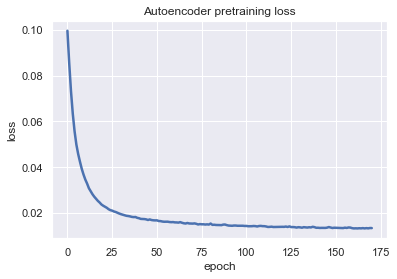

Iter:0 -> loss:0
Iter:140 -> loss:0.01871095411479473
Iter:280 -> loss:0.015731457620859146


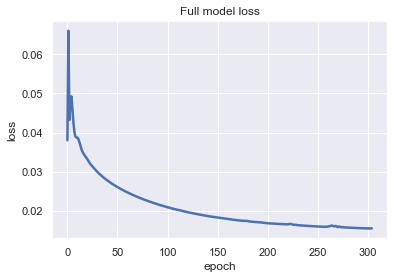

Training Done


In [ ]:
tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-all',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": None
        "noise_factor": 0.0,
    })
dc.make_model()
dc.train_model()

# Latent Head

## OPTICS

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...8 batches of 256 x 768


  0%|          | 0/8 [00:00<?, ?it/s]

Clustering 2000 points using OPTICS
Visualising
UMAP(metric='manhattan', verbose=True)
Thu Sep  1 15:34:58 2022 Construct fuzzy simplicial set
Thu Sep  1 15:35:01 2022 Finding Nearest Neighbors
Thu Sep  1 15:35:02 2022 Finished Nearest Neighbor Search
Thu Sep  1 15:35:03 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  1 15:35:06 2022 Finished embedding


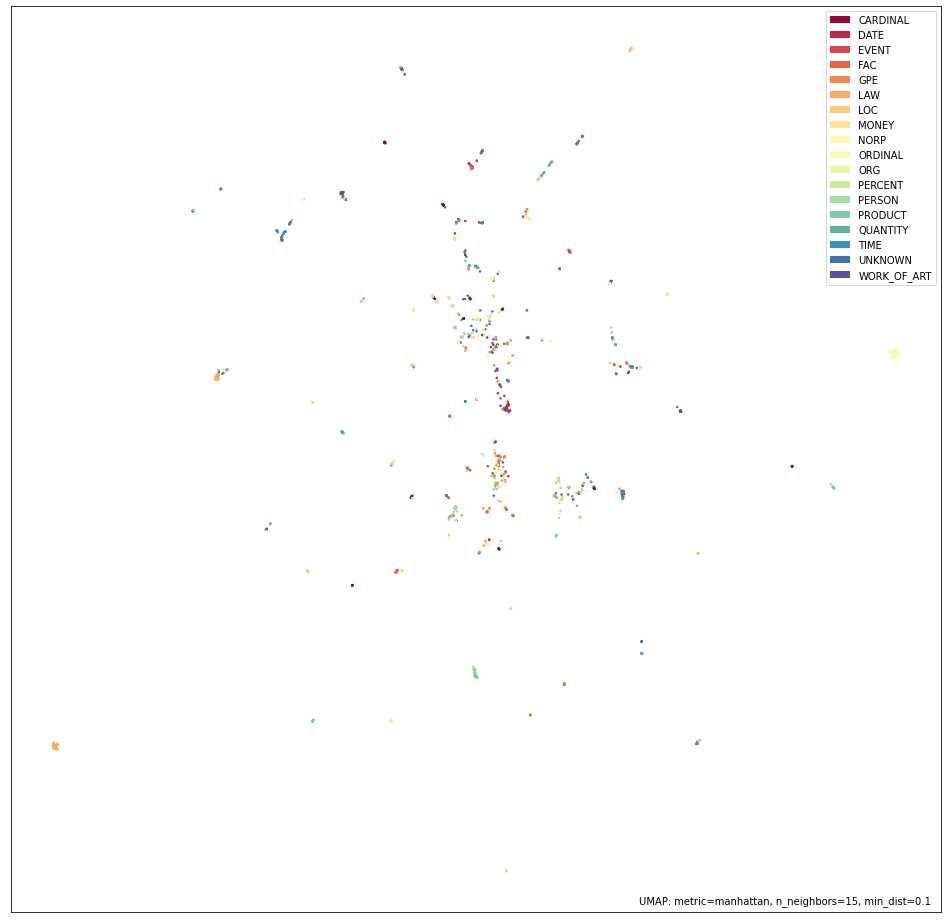

CLUSTERS
#PRODUCT:0 size:8 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-PRODUCT-1:1 size:8 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-PRODUCT-2:2 size:8 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-PRODUCT-3:3 size:9 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-PRODUCT-4:4 size:9 prec:1.0000 rec:1.0000 f1:1.0000
#LOC:5 size:10 prec:1.0000 rec:0.1562 f1:0.2703
#LAW:130 size:66 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-PRODUCT-7:7 size:7 prec:1.0000 rec:1.0000 f1:1.0000
#FAC:57 size:11 prec:1.0000 rec:0.2619 f1:0.4151
#UNK-FAC-9:8 size:6 prec:1.0000 rec:0.1143 f1:0.2051
#GPE:10 size:8 prec:1.0000 rec:0.0784 f1:0.1455
#QUANTITY:11 size:6 prec:1.0000 rec:0.1176 f1:0.2105
#UNK-QUANTITY-12:12 size:11 prec:1.0000 rec:0.1346 f1:0.2373
#UNK-QUANTITY-13:13 size:5 prec:1.0000 rec:0.1000 f1:0.1818
#MONEY:14 size:8 prec:1.0000 rec:0.2286 f1:0.3721
#UNK-MONEY-15:15 size:7 prec:1.0000 rec:0.2059 f1:0.3415
#PERCENT:16 size:6 prec:1.0000 rec:0.1224 f1:0.2182
#UNK-PERCENT-17:17 size:6 prec:1.0000 rec:0.1224 f1:0.2182
#UNK-MONEY-18:1

In [ ]:
#%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', sample_size=2000)

## Agglomerative Clustering

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using agg
Visualising
UMAP(metric='manhattan', verbose=True)
Thu Sep  1 15:43:50 2022 Construct fuzzy simplicial set
Thu Sep  1 15:44:00 2022 Finding Nearest Neighbors
Thu Sep  1 15:44:01 2022 Finished Nearest Neighbor Search
Thu Sep  1 15:44:02 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  1 15:44:08 2022 Finished embedding


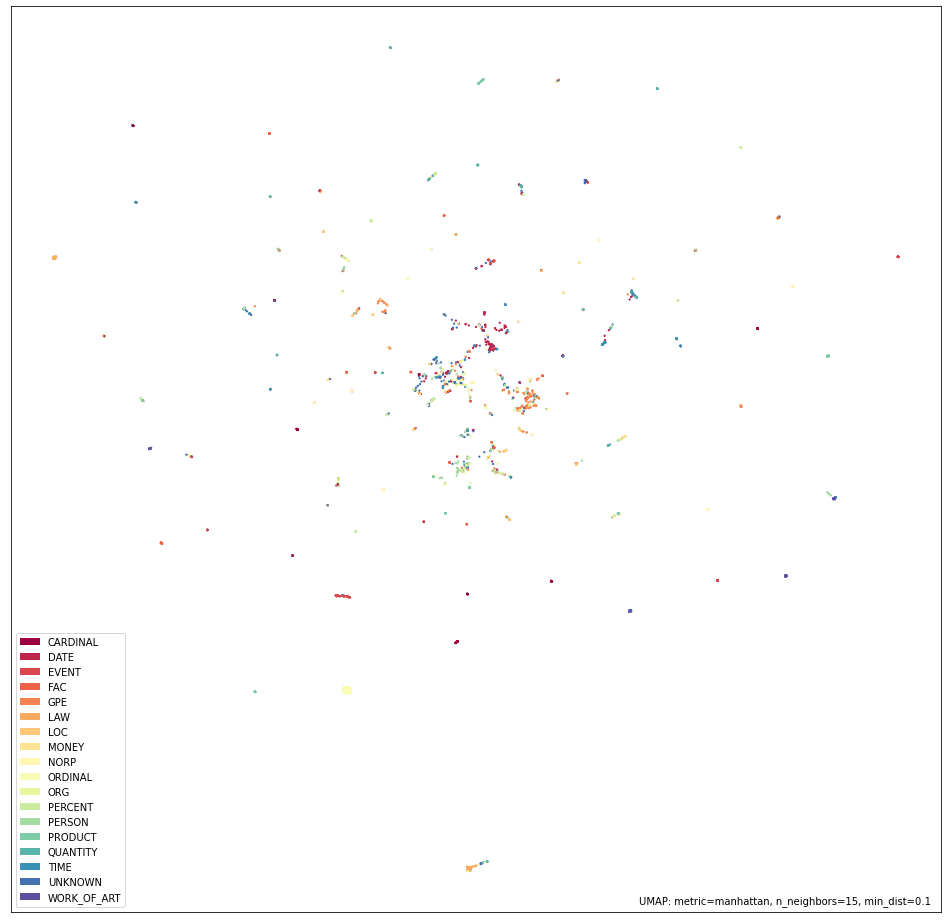

CLUSTERS
#EVENT:0 size:342 prec:1.0000 rec:0.6471 f1:0.7857
#NORP:12 size:21 prec:1.0000 rec:0.1257 f1:0.2234
#PERCENT:8 size:252 prec:1.0000 rec:0.4360 f1:0.6073
#LOC:3 size:125 prec:1.0000 rec:0.1287 f1:0.2281
#TIME:4 size:210 prec:1.0000 rec:0.3030 f1:0.4651
#CARDINAL:5 size:23 prec:1.0000 rec:0.1008 f1:0.1831
#MONEY:10 size:314 prec:1.0000 rec:0.5890 f1:0.7413
#UNK-CARDINAL-7:7 size:103 prec:1.0000 rec:0.1773 f1:0.3012
#UNK-PERCENT-8:2 size:285 prec:1.0000 rec:0.3742 f1:0.5446
#FAC:9 size:162 prec:1.0000 rec:0.2044 f1:0.3395
#UNK-MONEY-10:6 size:172 prec:1.0000 rec:0.3853 f1:0.5563
#WORK_OF_ART:11 size:101 prec:1.0000 rec:0.1696 f1:0.2901
#UNK-NORP-12:1 size:320 prec:1.0000 rec:0.3048 f1:0.4672
#PRODUCT:13 size:40 prec:1.0000 rec:0.4598 f1:0.6299
#UNK-PRODUCT-14:14 size:209 prec:1.0000 rec:0.6357 f1:0.7773
#ORDINAL:15 size:222 prec:1.0000 rec:1.0000 f1:1.0000
#UNK-NORP-16:16 size:30 prec:1.0000 rec:0.0875 f1:0.1609
#GPE:17 size:292 prec:1.0000 rec:0.4802 f1:0.6488
#UNK-CARDINAL-18:

In [13]:
%%time

tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-all-agg',
    {
        'train_size':10000,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "agg"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', sample_size=4000)

## K-means

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using Kmeans
Initialization complete
Iteration 0, inertia 1839.0250244140625.
Iteration 1, inertia 1415.8192138671875.
Iteration 2, inertia 1373.72265625.
Iteration 3, inertia 1363.353759765625.
Iteration 4, inertia 1358.4888916015625.
Iteration 5, inertia 1355.5079345703125.
Iteration 6, inertia 1353.782958984375.
Iteration 7, inertia 1352.50341796875.
Iteration 8, inertia 1350.2373046875.
Iteration 9, inertia 1348.6141357421875.
Iteration 10, inertia 1346.5179443359375.
Iteration 11, inertia 1346.278564453125.
Iteration 12, inertia 1346.1708984375.
Iteration 13, inertia 1345.4415283203125.
Iteration 14, inertia 1344.7567138671875.
Iteration 15, inertia 1344.706787109375.
Iteration 16, inertia 1344.6885986328125.
Iteration 17, inertia 1344.6710205078125.
Iteration 18, inertia 1344.639404296875.
Iteration 19, inertia 1344.629150390625.
Iteration 20, inertia 1344.607177734375.
Iteration 21, inertia 1344.59521484375.
Iteration 22, inertia 1344.585205078125.
Iterati

Epochs completed:   0%|            0/500 [00:00]

Thu Sep  1 15:45:09 2022 Finished embedding


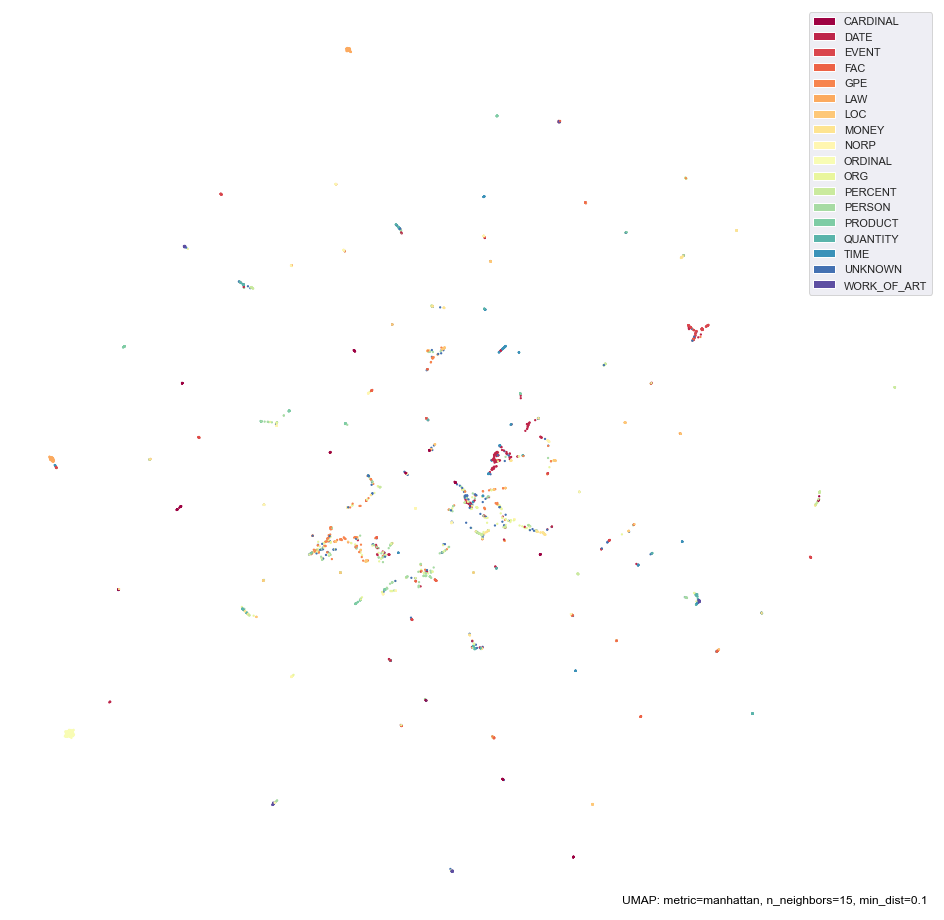

CLUSTERS
#NORP:12 size:11 prec:1.0000 rec:0.0797 f1:0.1477
#ORDINAL:1 size:220 prec:1.0000 rec:1.0000 f1:1.0000
#GPE:2 size:353 prec:1.0000 rec:0.3113 f1:0.4748
#QUANTITY:3 size:74 prec:1.0000 rec:0.2985 f1:0.4598
#LAW:14 size:123 prec:1.0000 rec:1.0000 f1:1.0000
#WORK_OF_ART:7 size:174 prec:1.0000 rec:0.5097 f1:0.6752
#UNK-QUANTITY-6:6 size:341 prec:1.0000 rec:0.5437 f1:0.7044
#UNK-WORK_OF_ART-7:5 size:131 prec:1.0000 rec:0.3821 f1:0.5529
#PERCENT:8 size:310 prec:1.0000 rec:0.6854 f1:0.8134
#CARDINAL:9 size:154 prec:1.0000 rec:0.3741 f1:0.5445
#TIME:10 size:176 prec:1.0000 rec:0.3714 f1:0.5417
#UNK-CARDINAL-11:11 size:227 prec:1.0000 rec:0.3741 f1:0.5445
#UNK-NORP-12:0 size:190 prec:1.0000 rec:0.1962 f1:0.3280
#PRODUCT:13 size:57 prec:1.0000 rec:0.4902 f1:0.6579
#UNK-LAW-14:4 size:282 prec:1.0000 rec:1.0000 f1:1.0000
#LOC:15 size:168 prec:1.0000 rec:0.3175 f1:0.4820
#DATE:16 size:184 prec:1.0000 rec:0.3624 f1:0.5321
#EVENT:17 size:119 prec:1.0000 rec:0.4820 f1:0.6505
#UNK-PRODUCT-18:1

In [14]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-Kmeans',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', sample_size=4000)

## GMM

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [z] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...16 batches of 256 x 768


  0%|          | 0/16 [00:00<?, ?it/s]

Clustering 4000 points using GMM
Initialization 0
  Iteration 10
Initialization converged: True
Visualising
UMAP(metric='manhattan', verbose=True)
Thu Sep  1 15:47:49 2022 Construct fuzzy simplicial set
Thu Sep  1 15:47:59 2022 Finding Nearest Neighbors
Thu Sep  1 15:47:59 2022 Finished Nearest Neighbor Search
Thu Sep  1 15:47:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  1 15:48:05 2022 Finished embedding


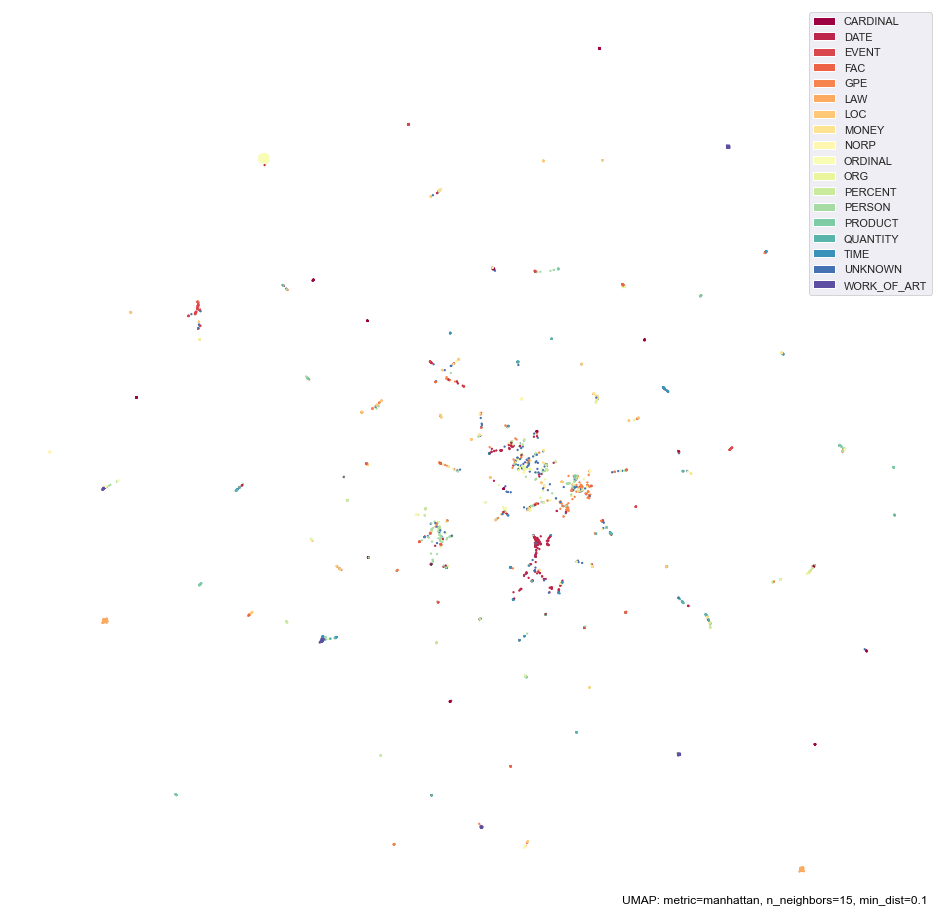

CLUSTERS
#QUANTITY:0 size:207 prec:1.0000 rec:0.4135 f1:0.5850
#LOC:2 size:160 prec:1.0000 rec:0.3660 f1:0.5359
#UNK-LOC-2:1 size:101 prec:1.0000 rec:0.1917 f1:0.3217
#MONEY:3 size:101 prec:1.0000 rec:0.2113 f1:0.3488
#UNK-LOC-4:4 size:190 prec:1.0000 rec:0.3822 f1:0.5530
#ORDINAL:5 size:244 prec:1.0000 rec:1.0000 f1:1.0000
#WORK_OF_ART:6 size:97 prec:1.0000 rec:0.3333 f1:0.5000
#CARDINAL:15 size:163 prec:1.0000 rec:0.4133 f1:0.5848
#UNK-UNKNOWN-8:8 size:198 prec:0.1919 rec:1.0000 f1:0.3220
#UNK-WORK_OF_ART-9:9 size:194 prec:1.0000 rec:0.4951 f1:0.6623
#LAW:10 size:125 prec:1.0000 rec:1.0000 f1:1.0000
#PRODUCT:11 size:29 prec:1.0000 rec:0.3000 f1:0.4615
#NORP:12 size:18 prec:1.0000 rec:0.0814 f1:0.1506
#TIME:13 size:175 prec:1.0000 rec:0.3507 f1:0.5193
#UNK-PRODUCT-14:14 size:182 prec:1.0000 rec:0.5227 f1:0.6866
#UNK-CARDINAL-15:7 size:158 prec:1.0000 rec:0.2484 f1:0.3979
#FAC:16 size:193 prec:1.0000 rec:0.1912 f1:0.3210
#UNK-LAW-17:17 size:204 prec:1.0000 rec:1.0000 f1:1.0000
#PERCENT

In [15]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', sample_size=4000)

# Encoder Head

Autoencoder
Latent Model
model compiled
Loading AE weights from ./results/test-latent-all\ae_weights.h5
Loading model weights from ./results/test-latent-all\lat_model_final.h5
Using [enc] head for predictions
Load Data 
Test Data Loaded (185490, 768)
Predicting...12 batches of 256 x 768


  0%|          | 0/12 [00:00<?, ?it/s]

Clustering 3000 points using OPTICS
Visualising
UMAP(metric='manhattan', verbose=True)
Thu Sep  1 15:51:35 2022 Construct fuzzy simplicial set
Thu Sep  1 15:51:37 2022 Finding Nearest Neighbors
Thu Sep  1 15:51:37 2022 Finished Nearest Neighbor Search
Thu Sep  1 15:51:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  1 15:51:42 2022 Finished embedding


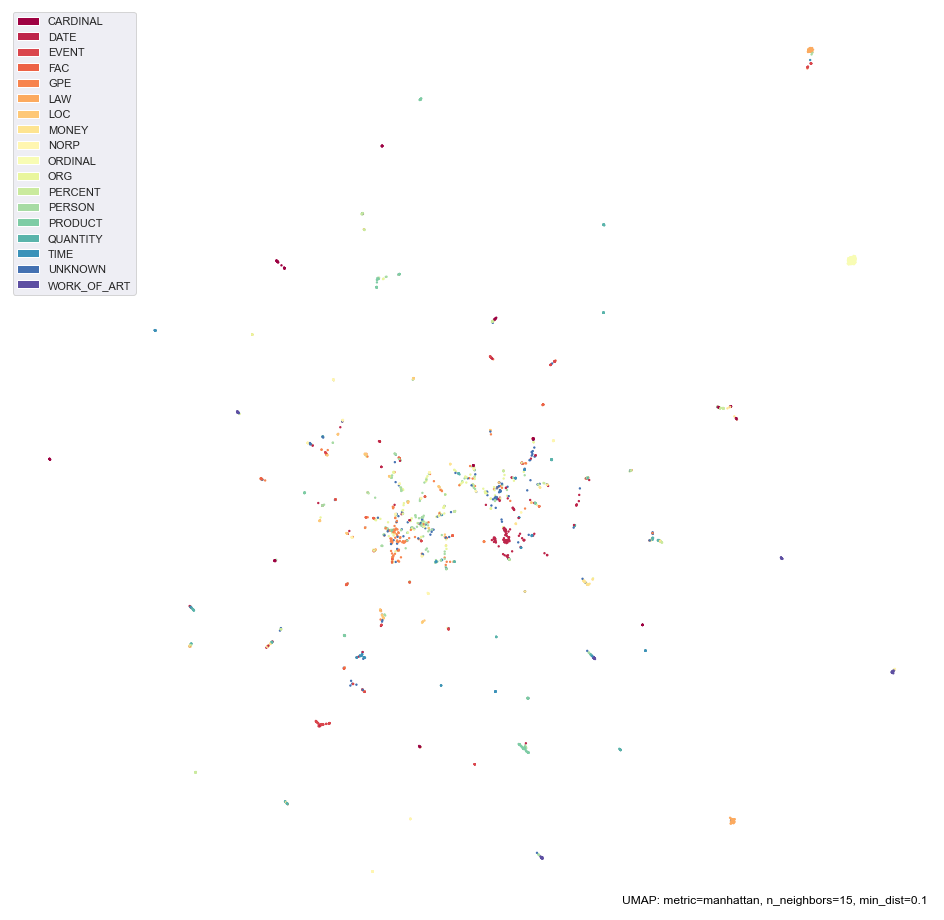

CLUSTERS
#TIME:0 size:6 prec:1.0000 rec:0.1765 f1:0.3000
#ORG:1 size:5 prec:1.0000 rec:0.0296 f1:0.0575
#QUANTITY:3 size:7 prec:1.0000 rec:0.2800 f1:0.4375
#UNK-QUANTITY-3:2 size:8 prec:1.0000 rec:0.2800 f1:0.4375
#MONEY:4 size:7 prec:1.0000 rec:0.1842 f1:0.3111
#UNK-MONEY-5:5 size:12 prec:1.0000 rec:0.2619 f1:0.4151
#UNK-MONEY-6:6 size:7 prec:1.0000 rec:0.1842 f1:0.3111
#UNK-QUANTITY-7:7 size:6 prec:1.0000 rec:0.2500 f1:0.4000
#UNK-MONEY-8:8 size:5 prec:1.0000 rec:0.1389 f1:0.2439
#UNK-QUANTITY-9:9 size:6 prec:1.0000 rec:0.2174 f1:0.3571
#UNK-QUANTITY-10:10 size:8 prec:1.0000 rec:0.3077 f1:0.4706
#UNK-QUANTITY-11:11 size:7 prec:1.0000 rec:0.2800 f1:0.4375
#UNK-QUANTITY-12:12 size:6 prec:1.0000 rec:0.2500 f1:0.4000
#UNK-MONEY-13:13 size:7 prec:1.0000 rec:0.1842 f1:0.3111
#UNK-MONEY-14:14 size:9 prec:1.0000 rec:0.2250 f1:0.3673
#UNK-QUANTITY-15:15 size:13 prec:1.0000 rec:0.4194 f1:0.5909
#WORK_OF_ART:16 size:33 prec:1.0000 rec:1.0000 f1:1.0000
#PERCENT:17 size:5 prec:1.0000 rec:0.1087 f

In [16]:
%%time
#min cluster size

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS-Enc-2',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=3000)

## Optics-Encoder

In [17]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS-Enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=3000, verbose=0)


F1 by Known Clusters: 0.3664
F1 score (macro) = 0.7463
Accuracy = 0.7440
Precision = 0.8982
Recall = 0.7440
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-Enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-Enc\index.html</a>
Finished 'evaluate_model' in 243.125 secs
CPU times: total: 59min 31s
Wall time: 4min 3s


## Agglomerative-Encoder

In [18]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-agg-enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "agg"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model('test-latent-all', head='enc',  sample_size=4000, verbose=0)


F1 by Known Clusters: 0.1845
F1 score (macro) = 0.5695
Accuracy = 0.5175
Precision = 0.8387
Recall = 0.5150
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-agg-enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-agg-enc\index.html</a>
Finished 'evaluate_model' in 31.461 secs
CPU times: total: 1min 46s
Wall time: 31.5 s


## KMeans-Encoder

In [19]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-Kmeans-Enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=4000, verbose=0)


F1 by Known Clusters: 0.2408
F1 score (macro) = 0.5193
Accuracy = 0.4617
Precision = 0.8381
Recall = 0.4648
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-Enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-Enc\index.html</a>
Finished 'evaluate_model' in 33.836 secs
CPU times: total: 2min 21s
Wall time: 33.8 s


## GMM-Encoder

In [20]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM-Enc',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })

dc.evaluate_model('test-latent-all', head="enc", sample_size=4000, verbose=0)


F1 by Known Clusters: 0.2066
F1 score (macro) = 0.5971
Accuracy = 0.5282
Precision = 0.8943
Recall = 0.5303
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-Enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-Enc\index.html</a>
Finished 'evaluate_model' in 34.057 secs
CPU times: total: 2min 1s
Wall time: 34.1 s


# Decoder Head


## Optics-AE

In [21]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-OPTICS-AE',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=3000, verbose=0)


F1 by Known Clusters: 0.3438
F1 score (macro) = 0.7530
Accuracy = 0.7370
Precision = 0.9542
Recall = 0.7368
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-AE\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-OPTICS-AE\index.html</a>
Finished 'evaluate_model' in 247.134 secs
CPU times: total: 1h 5min 14s
Wall time: 4min 7s


## GMM-AE

In [22]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM-AE2',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=4000, verbose=0)


F1 by Known Clusters: 0.4028
F1 score (macro) = 0.5491
Accuracy = 0.4950
Precision = 0.8938
Recall = 0.4948
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE2\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE2\index.html</a>
Finished 'evaluate_model' in 39.645 secs
CPU times: total: 2min 34s
Wall time: 39.6 s


In [23]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-GMM-AE',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "GMM"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=4000, verbose=0)


F1 by Known Clusters: 0.2943
F1 score (macro) = 0.5404
Accuracy = 0.4650
Precision = 0.8936
Recall = 0.4739
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-GMM-AE\index.html</a>
Finished 'evaluate_model' in 40.688 secs
CPU times: total: 2min 30s
Wall time: 40.7 s


## Kmeans-AE

In [24]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-all-Kmeans-AE',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })

dc.evaluate_model('test-latent-all', head="ae", sample_size=4000, verbose=0)


F1 by Known Clusters: 0.3031
F1 score (macro) = 0.5619
Accuracy = 0.5060
Precision = 0.7830
Recall = 0.5057
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-AE\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-all-Kmeans-AE\index.html</a>
Finished 'evaluate_model' in 35.418 secs
CPU times: total: 2min 31s
Wall time: 35.4 s


In [25]:
stop

NameError: name 'stop' is not defined

# Benchmark

In [26]:
%%time

dc = None
dc = DeepLatentCluster(
    'test-latent-10k-Benchmark',
    {
        'train_size':0,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })
# dc.make_model()
# dc.train_model()
dc.benchmark_model(sample_size=4000, verbose=0)


F1 by Known Clusters: 0.2117
F1 score (macro) = 0.5419
Accuracy = 0.4855
Precision = 0.8387
Recall = 0.4795
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-10k-Benchmark\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-10k-Benchmark\index.html</a>
CPU times: total: 2min 4s
Wall time: 30.6 s


In [ ]:
stop

In [ ]:
tf.get_logger().setLevel('ERROR')

dc = DeepLatentCluster(
    'test-latent-all-10ent',
    {
        'entity_count': 10,
        'train_size':0,
        'reconstr_weight':1.0, 'latent_weight':1e-5
    })
dc.make_model()
# dc.train_model()

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled


In [ ]:
dc.evaluate_model(10000, sample_size=1000)

Load Data
Loading ./data/conll_spacy_10000_test.pkl
LOADED {1: 'UNKNOWN', 2: 'PERSON', 4: 'ORG', 5: 'GPE', 11: 'DATE', 12: 'TIME', 8: 'EVENT', 16: 'ORDINAL', 3: 'NORP', 14: 'MONEY', 15: 'QUANTITY', 18: 'FAC', 6: 'LOC', 7: 'PRODUCT', 10: 'LAW', 9: 'WORK_OF_ART', 17: 'CARDINAL', 13: 'PERCENT'}
Loaded file: 12479 samples
Data balance:
[[    1 10305]
 [    2   404]
 [    3    24]
 [    4   439]
 [    5   668]
 [    6    44]
 [    7    14]
 [    8    24]
 [    9     5]
 [   10     2]
 [   11   380]
 [   12    31]
 [   13    38]
 [   14    30]
 [   15    29]
 [   16     1]
 [   17    15]
 [   18    26]]
Balancing data
Post Oversampling
x: (185490, 768), y: (185490,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LAW', 10: 'DATE', 11: 'TIME', 12: 'PERCENT', 13: 'MONEY', 14: 'QUANTITY', 15: 'ORDINAL', 16: 'CARDINAL', 17: 'FAC'}
Test Data Loaded
Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500

  0%|          | 0/724 [00:00<?, ?it/s]

Clustering 1000 points
Initialization 0
Initialization converged: True	 time lapse 19.37085s	 ll 11881.56552
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 10:53:04 2022 Construct fuzzy simplicial set
Sat Aug 27 10:53:05 2022 Finding Nearest Neighbors
Sat Aug 27 10:53:07 2022 Finished Nearest Neighbor Search
Sat Aug 27 10:53:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 10:53:11 2022 Finished embedding
CLUSTERS


# Hypertuning

In [ ]:
# optimal eps https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

from sklearn.neighbors import NearestNeighbors

def optimal_eps(X, n_neighbors=10):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [ ]:
def hypertune_density_clustering():
    """
    hypertune the density clustering algorithms.
    """
    eps_vals = [30000.0, 40000.0, 50000.0]
    x, y, mapping, strings = load_data(
                                    1000,
                                    oversample=True,
                                    get_text=True)
    print(f"Optimal epsilon: {optimal_eps(x)}")
    for eps in eps_vals:
        # predict cluster labels
        print(f"Predicting...for epsilon={eps}")
        y_pred, _ = do_clustering('DBSCAN', 25, x, params={'eps':eps})
        print(f"ACC: {cluster_score(y, y_pred, 25)}")
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y, y_pred, mapping, size=cm_width, save_dir=None, details=False)

In [ ]:
hypertune_density_clustering()

# Train with noise

Autoencoder
Latent Model
model compiled
Load Data
Loading ./data/conll_spacy_0.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Loaded file: 9153 samples
Data balance:
[[   2 2080]
 [   3  142]
 [   4 1950]
 [   5 2664]
 [   6  114]
 [  12 1659]
 [  13  143]
 [  14  151]
 [  15  111]
 [  16  139]]
Balancing data
Post Oversampling
x: (26640, 768), y: (26640,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 1/1000
105/105 [==============================] - 1s 4ms/step - loss: 0.0924
Epoch 2/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0770
Epoch 3/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0635
Epoch 4/1000
10

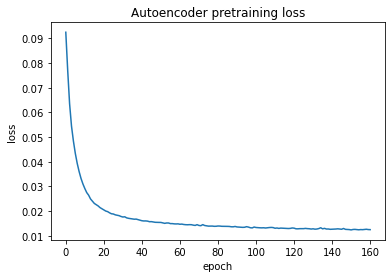

Iter:0 -> loss:0
Iter:140 -> loss:0.278009831905365
Iter:280 -> loss:0.2712785005569458
Iter:420 -> loss:0.2684745490550995
Iter:560 -> loss:0.26624009013175964
Iter:700 -> loss:0.2647261321544647
Iter:840 -> loss:0.2643788456916809
Iter:980 -> loss:0.2628762125968933
Iter:1120 -> loss:0.26055970788002014
Iter:1260 -> loss:0.25919196009635925
Iter:1400 -> loss:0.25956857204437256
Iter:1540 -> loss:0.25874316692352295
Iter:1680 -> loss:0.257563054561615
Iter:1820 -> loss:0.25634926557540894
Iter:1960 -> loss:0.25867974758148193
Iter:2100 -> loss:0.2588096261024475
Iter:2240 -> loss:0.2559618055820465
Iter:2380 -> loss:0.25514480471611023
Iter:2520 -> loss:0.25673210620880127
Iter:2660 -> loss:0.25658857822418213
Iter:2800 -> loss:0.25567519664764404
Iter:2940 -> loss:0.2567903995513916
Iter:3080 -> loss:0.25481992959976196
Iter:3220 -> loss:0.2557295858860016
Iter:3360 -> loss:0.2556922733783722
Iter:3500 -> loss:0.2565091550350189
Iter:3640 -> loss:0.255708783864975
Iter:3780 -> loss:0

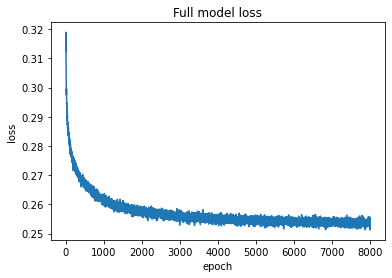

Training Done


In [ ]:
tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
        'test-latent-noise',
        {
            'train_size':0,
            'reconstr_weight':1.0,
            'latent_weight':1e-5,
            "cluster": None,
            "noise_factor": 0.5,
        })
dc.make_model()
dc.train_model(verbose=0)

# Evaluate all 

## different entity counts in training

## No noise

In [27]:
for entity_count in [0, 5, 10, 15]:
    run_name = f'test-latent-no-noise-{entity_count}-ents'
    print('-'*50)
    print(f"{run_name}")
    print('-'*50)

    dc = None
    dc = DeepLatentCluster(
        run_name,
        {
            'train_size':0,
            'reconstr_weight':1.0,
            'latent_weight':1e-5,
            "cluster": 'Kmeans',
            "entity_count": entity_count,
        })
    dc.make_model()
    # dc.train_model(verbose=0)
    dc.evaluate_model(
            run_name,
            head='z',
            sample_size=4000,
            verbose=0)

--------------------------------------------------
test-latent-no-noise-0-ents
--------------------------------------------------
Autoencoder
Latent Model
model compiled

F1 by Known Clusters: 0.3051
F1 score (macro) = 0.4944
Accuracy = 0.4587
Precision = 0.7829
Recall = 0.4543
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-no-noise-0-ents\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-no-noise-0-ents\index.html</a>
Finished 'evaluate_model' in 42.866 secs
--------------------------------------------------
test-latent-no-noise-5-ents
--------------------------------------------------
Autoencoder
Latent Model
model compiled

F1 by Known Clusters: 0.2722
F1 score (macro) = 0.5432
Accuracy = 0.4943
Precision = 0.8392
Recall = 0.4903
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-no-noise-5-ents\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-no-noise-5-ents\index.

## with noise

In [28]:
for entity_count in [0, 5, 10, 15]:
    run_name = f'test-latent-noise-{entity_count}-ents'
    print('-'*50)
    print(f"{run_name}")
    print('-'*50)

    dc = None
    dc = DeepLatentCluster(
        run_name,
        {
            'train_size':0,
            'reconstr_weight':1.0,
            'latent_weight':1e-5,
            "cluster": 'Kmeans',
            "entity_count": entity_count,
            "noise_factor": 0.5,
        })
    dc.make_model()
    # dc.train_model(verbose=0)
    dc.evaluate_model(
            run_name,
            head='z',
            sample_size=4000,
            verbose=0)

--------------------------------------------------
test-latent-noise-0-ents
--------------------------------------------------
Autoencoder
Latent Model
model compiled

F1 by Known Clusters: 0.2405
F1 score (macro) = 0.5152
Accuracy = 0.4475
Precision = 0.8383
Recall = 0.4500
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-0-ents\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-0-ents\index.html</a>
Finished 'evaluate_model' in 43.886 secs
--------------------------------------------------
test-latent-noise-5-ents
--------------------------------------------------
Autoencoder
Latent Model
model compiled

F1 by Known Clusters: 0.2957
F1 score (macro) = 0.5189
Accuracy = 0.4775
Precision = 0.7834
Recall = 0.4716
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-5-ents\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-5-ents\index.html</a>
Finished 

# Grid Search Clustering

## with noise

In [29]:
heads = ["z", "ae", "enc"]
clusterers = {"Kmeans": 4000, "GMM": 4000, "OPTICS":3000, "agg":4000}

for head in heads:
    for clusterer in clusterers:
        run_name = f'test-latent-noise-15-ents-{head}-{clusterer}'
        print('-'*50)
        print(f"{run_name}")
        print('-'*50)
        
        dc = None
        dc = DeepLatentCluster(
            run_name,
            {
                'train_size':0,
                'reconstr_weight':1.0,
                'latent_weight':1e-5,
                "cluster": clusterer,
            })
        
        dc.evaluate_model(
                f'test-latent-noise-15-ents',
                head=head,
                sample_size=clusterers[clusterer],
                verbose=0)

--------------------------------------------------
test-latent-noise-15-ents-z-Kmeans
--------------------------------------------------

F1 by Known Clusters: 0.2015
F1 score (macro) = 0.5382
Accuracy = 0.4758
Precision = 0.8388
Recall = 0.4770
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-Kmeans\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-Kmeans\index.html</a>
Finished 'evaluate_model' in 43.81 secs
--------------------------------------------------
test-latent-noise-15-ents-z-GMM
--------------------------------------------------

F1 by Known Clusters: 0.2109
F1 score (macro) = 0.5343
Accuracy = 0.4713
Precision = 0.8939
Recall = 0.4695
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-GMM\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-GMM\index.html</a>
Finished 'evaluate_model' in 240.687 se

## Evaluate all without noise

In [30]:
heads = ["z", "ae", "enc"]
clusterers = {"Kmeans": 4000, "GMM": 4000, "OPTICS":3000, "agg":4000}

for head in heads:
    for clusterer in clusterers:
        run_name = f'test-latent-noise-15-ents-{head}-{clusterer}'
        print('-'*50)
        print(f"{run_name}")
        print('-'*50)
        
        dc = None
        dc = DeepLatentCluster(
            run_name,
            {
                'train_size':0,
                'reconstr_weight':1.0,
                'latent_weight':1e-5,
                "cluster": clusterer,
            })
        
        dc.evaluate_model(
                f'test-latent-noise-15-ents',
                head=head,
                sample_size=clusterers[clusterer],
                verbose=0)

--------------------------------------------------
test-latent-noise-15-ents-z-Kmeans
--------------------------------------------------

F1 by Known Clusters: 0.2550
F1 score (macro) = 0.5139
Accuracy = 0.4577
Precision = 0.7829
Recall = 0.4565
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-Kmeans\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-Kmeans\index.html</a>
Finished 'evaluate_model' in 43.82 secs
--------------------------------------------------
test-latent-noise-15-ents-z-GMM
--------------------------------------------------

F1 by Known Clusters: 0.1875
F1 score (macro) = 0.5224
Accuracy = 0.4517
Precision = 0.8938
Recall = 0.4510
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-GMM\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-z-GMM\index.html</a>
Finished 'evaluate_model' in 198.58 sec

# Radius BMs

In [31]:
assert False, "One time run"
for radius in [0,1,2,4,6]:
    load_data(0, oversample=False, radius=radius, verbose=0)

AssertionError: One time run

## Z-head different radii

In [32]:
for radius in [0,1,2,4,6]:
    run_name = f'test-latent-noise-15-ents-r{radius}-Kmeans'
    print('-'*50)
    print(f"{run_name}")
    print('-'*50)
    
    dc = None
    dc = DeepLatentCluster(
        run_name,
        {
            'train_size':0,
            'reconstr_weight':1.0,
            'latent_weight':1e-5,
            "cluster": "Kmeans",
            "radius": radius,
        })
    # dc.make_model()
    # dc.train_model(verbose=0)
    dc.evaluate_model(
            run_name,
            head="z",
            sample_size=4000,
            verbose=0)

--------------------------------------------------
test-latent-noise-15-ents-r0-Kmeans
--------------------------------------------------

F1 by Known Clusters: 0.2609
F1 score (macro) = 0.5668
Accuracy = 0.5055
Precision = 0.8950
Recall = 0.5067
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r0-Kmeans\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r0-Kmeans\index.html</a>
Finished 'evaluate_model' in 43.838 secs
--------------------------------------------------
test-latent-noise-15-ents-r1-Kmeans
--------------------------------------------------

F1 by Known Clusters: 0.1956
F1 score (macro) = 0.5794
Accuracy = 0.5102
Precision = 0.8943
Recall = 0.5122
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r1-Kmeans\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r1-Kmeans\index.html</a>
Finished 'evaluate_mode

## Encoder head, different radii

--------------------------------------------------
test-latent-noise-15-ents-r0-Kmeans-enc
--------------------------------------------------
Autoencoder
Latent Model
model compiled
Epoch 187: early stopping


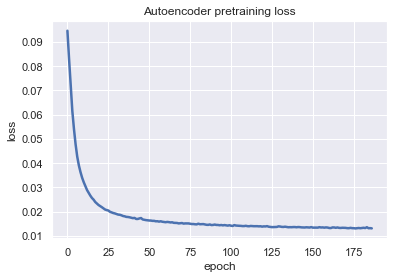

Stop traing for tolerance threshold reached
Iter: 868 loss=0.014314218424260616


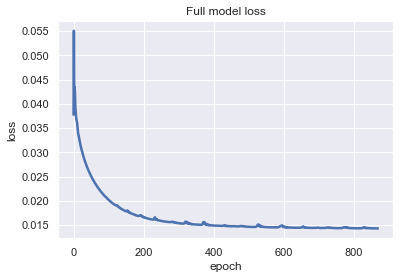

Training Done

F1 by Known Clusters: 0.2339
F1 score (macro) = 0.5587
Accuracy = 0.4918
Precision = 0.8388
Recall = 0.4949
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r0-Kmeans-enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r0-Kmeans-enc\index.html</a>
Finished 'evaluate_model' in 33.369 secs
--------------------------------------------------
test-latent-noise-15-ents-r1-Kmeans-enc
--------------------------------------------------
Autoencoder
Latent Model
model compiled
Epoch 131: early stopping


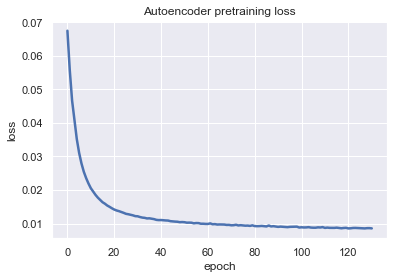

Stop traing for tolerance threshold reached
Iter: 640 loss=0.014355950057506561


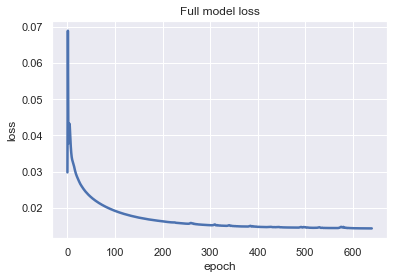

Training Done

F1 by Known Clusters: 0.2053
F1 score (macro) = 0.5658
Accuracy = 0.5005
Precision = 0.8386
Recall = 0.5064
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r1-Kmeans-enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r1-Kmeans-enc\index.html</a>
Finished 'evaluate_model' in 32.74 secs
--------------------------------------------------
test-latent-noise-15-ents-r2-Kmeans-enc
--------------------------------------------------
Autoencoder
Latent Model
model compiled
Epoch 205: early stopping


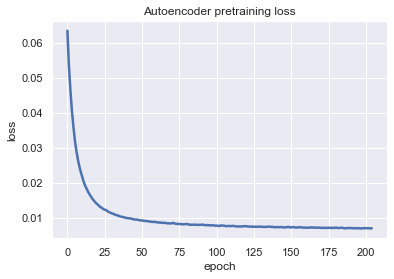

Stop traing for tolerance threshold reached
Iter: 872 loss=0.014387383125722408


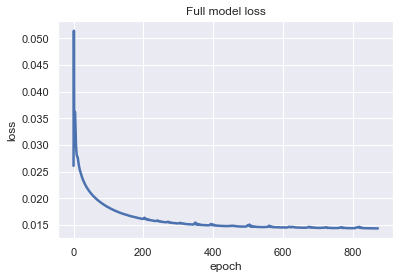

Training Done

F1 by Known Clusters: 0.1892
F1 score (macro) = 0.5717
Accuracy = 0.5122
Precision = 0.8944
Recall = 0.5163
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r2-Kmeans-enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r2-Kmeans-enc\index.html</a>
Finished 'evaluate_model' in 34.179 secs
--------------------------------------------------
test-latent-noise-15-ents-r4-Kmeans-enc
--------------------------------------------------
Autoencoder
Latent Model
model compiled
Epoch 159: early stopping


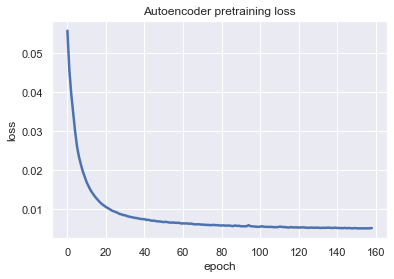

Stop traing for tolerance threshold reached
Iter: 540 loss=0.014548246748745441


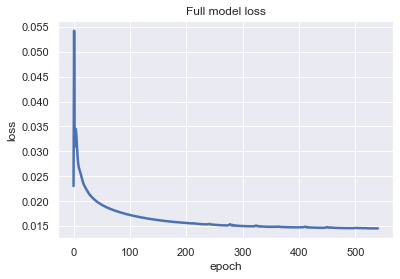

Training Done

F1 by Known Clusters: 0.3049
F1 score (macro) = 0.5425
Accuracy = 0.5045
Precision = 0.7280
Recall = 0.5004
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r4-Kmeans-enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r4-Kmeans-enc\index.html</a>
Finished 'evaluate_model' in 33.141 secs
--------------------------------------------------
test-latent-noise-15-ents-r6-Kmeans-enc
--------------------------------------------------
Autoencoder
Latent Model
model compiled
Epoch 151: early stopping


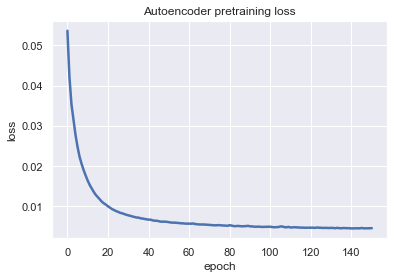

Stop traing for tolerance threshold reached
Iter: 518 loss=0.014504999853670597


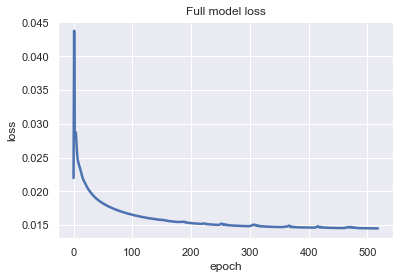

Training Done

F1 by Known Clusters: 0.3222
F1 score (macro) = 0.5318
Accuracy = 0.5030
Precision = 0.7277
Recall = 0.4930
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r6-Kmeans-enc\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-noise-15-ents-r6-Kmeans-enc\index.html</a>
Finished 'evaluate_model' in 32.811 secs


In [33]:

for radius in [0,1,2,4,6]:
    run_name = f'test-latent-noise-15-ents-r{radius}-Kmeans-enc'
    print('-'*50)
    print(f"{run_name}")
    print('-'*50)
    
    dc = None
    dc = DeepLatentCluster(
        run_name,
        {
            'train_size':0,
            'reconstr_weight':1.0,
            'latent_weight':1e-5,
            "cluster": "Kmeans",
            "radius": radius,
        })
    dc.make_model()
    dc.train_model(verbose=0)
    dc.evaluate_model(
            run_name,
            head="enc",
            sample_size=4000,
            verbose=0)